# Visualise trajectories for different models

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations
import tensorflow as tf
from dynamical_system import XYModelSystem, RelativisticChargedParticleSystem, DoubleWellPotentialSystem, TwoParticleSystem
from initializer import XYModelRandomInitializer, RelativisticChargedParticleRandomInitializer, DoubleWellPotentialConstantInitializer, TwoParticleConstantInitializer
from time_integrator import RK4Integrator
%matplotlib inline


In [2]:
class Monitor(object):
    def __init__(self,dim):
        """Class for accumulating data over a trajectory

        :arg dim: phase space dimension of dynamical system
        """
        self.dim = dim
        self.reset(0)

    def reset(self,nsteps):
        """Reset state"""
        self.j_step = 0

class PositionMonitor(Monitor):
    """Monitor for current position
    
    :arg dim: dimension of dynamical system
    """
    def __init__(self, dim):
        super(PositionMonitor,self).__init__(dim)

    def reset(self,nsteps):
        """reset the monitor to start new accumulation
        
        :arg nsteps: number of steps
        """
        super(PositionMonitor,self).reset(nsteps)
        self.q_all = np.zeros((self.dim, nsteps+1))

    @property
    def value(self):
        """Return monitored quantity"""
        return self.q_all

    def __call__(self,time_integrator):
        """Evaluate the monitor for the current state of the time_integrator
        
        :arg time_integrator: time integrator to monitor
        """
        self.q_all[:,self.j_step] = time_integrator.q[:]
        self.j_step += 1

class VelocitySumMonitor(Monitor):
    """Monitor for sum of velocities
    
    :arg dim: dimension of dynamical system
    """
    def __init__(self, dim):
        super(VelocitySumMonitor,self).__init__(dim)

    @property
    def value(self):
        """Return monitored quantity"""
        return self.sum_qdot

    def reset(self,nsteps):
        """reset the monitor to start new accumulation
        
        :arg nsteps: number of steps
        """
        super(VelocitySumMonitor,self).reset(nsteps)
        self.sum_qdot = np.zeros(nsteps+1)

    def __call__(self, time_integrator):
        """Evaluate the monitor for the current state of the time_integrator
        
        :arg time_integrator: time integrator to monitor
        """
        self.sum_qdot[self.j_step] = np.sum(time_integrator.qdot[:])
        self.j_step += 1
            
class TrajectoryGenerator(object):
    def __init__(self,dynamical_system,initializer,monitors,dt=0.01,t_final=1.0):
        """Generate trajectory by numerically integrating the chosen dynamical system
    
        :arg dynamical_system: system to integrate
        :arg initializer: initialiser object
        :arg dt: numerical timestep size
        :arg t_final: final time
        """
        self.dim = dynamical_system.dim
        self.dynamical_system = dynamical_system
        self.initializer = initializer
        self.dt = dt
        self.t_final = t_final
        self.monitors = monitors
        nsteps = int(self.t_final/self.dt)
        self.t = np.zeros(nsteps+1)
        for monitor in self.monitors:
            monitor.reset(int(self.t_final/self.dt))
        self.time_integrator = RK4Integrator(self.dynamical_system,self.dt)

    def run(self):
        """Integrate the dynamical system forward in time, while monitoring quantities"""
        q, qdot = self.initializer.draw()
        nsteps = int(self.t_final/self.dt)
        t = np.zeros(nsteps+1)
        self.time_integrator.set_state(q,qdot)
        for j in range(nsteps+1):
            for monitor in self.monitors:
                monitor(self.time_integrator)
            self.t[j] = j*self.dt
            self.time_integrator.integrate(1)

## XY Model system
Plot the positions $q_j$ and the sum of all velocities $\sum_{j=0}^{d-1}\dot{q}_j$. Note that this sum should be constant since the Lagrangian is invariant under global rotations

$$
\mathcal{L}(\theta_0+\phi,\theta_1+\phi,\dots,\theta_{d-1}+\phi) = \mathcal{L}(\theta_0,\theta_1,\dots,\theta_{d-1})
$$

Text(0.5, 1.0, 'Sum of all velocities')

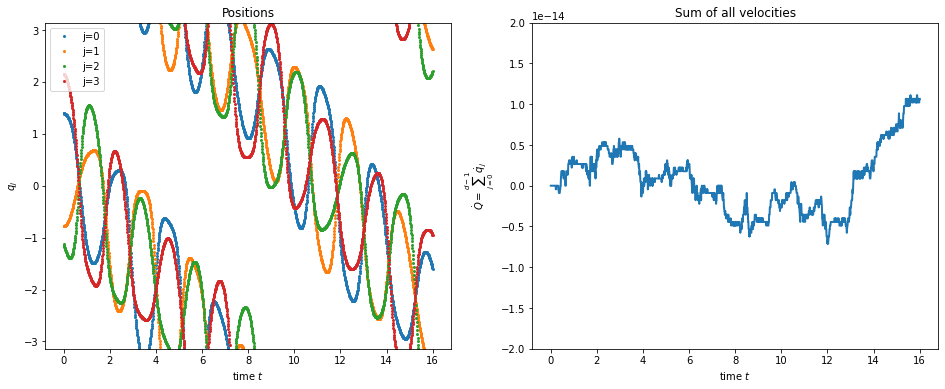

In [3]:
np.random.seed(2145127)
dim = 4
dynamical_system = XYModelSystem(dim)

monitors = [PositionMonitor(dim),VelocitySumMonitor(dim)]
initializer = XYModelRandomInitializer(dim)

trajectory_generator1 = TrajectoryGenerator(dynamical_system,initializer,monitors,dt=0.01,t_final=16.0)
trajectory_generator1.run()

# Map to interval [-pi,+pi]
def map_to_interval(x):
    return x - 2.*np.pi*((x+np.pi)//(2.*np.pi))

q_all = np.vectorize(map_to_interval)(trajectory_generator1.monitors[0].value)
sum_qdot = trajectory_generator1.monitors[1].value

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))

# Plot position
for j in range(dim):
    ax1.plot(trajectory_generator1.t,q_all[j,:],linewidth=0,marker="o",markersize=2,label=f"j={j:d}")
ax1.set_xlabel("time $t$")
ax1.set_ylabel("$q_j$")
ax1.set_ylim(-np.pi,+np.pi)
ax1.legend(loc="upper left")
ax1.set_title("Positions")

# Plot sum of all velocities
ax2.set_ylim(-2.E-14,+2.E-14)
ax2.plot(trajectory_generator1.t,sum_qdot-sum_qdot[0],linewidth=2)
ax2.set_xlabel("time $t$")
ax2.set_ylabel(r"$\dot{Q} = \sum_{j=0}^{d-1}\dot{q}_j$")
ax2.set_title("Sum of all velocities")

## Charged particle in electrodynamic field
This assumes a vertically varying electric field generated by a quadratic potential.

Text(0.5, 0.92, 'Trajectories in 3d space')

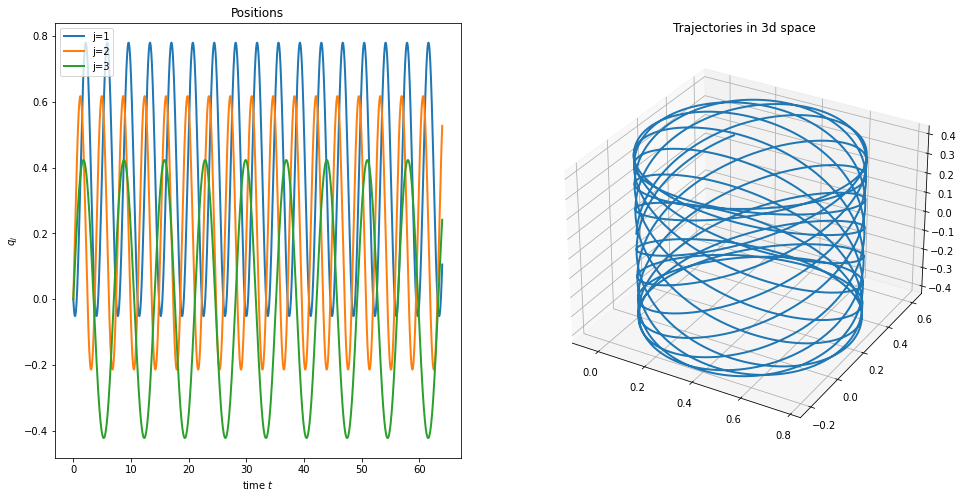

In [4]:
np.random.seed(2145127)
dim = 4
mass = 1.1
charge = 0.93
E_electric = [0, 0, 1.0]
B_magnetic = [0, 0, 2.0]
B = np.asarray(B_magnetic)

dynamical_system = RelativisticChargedParticleSystem(mass, charge, E_electric, B_magnetic, constant_E_electric=False)

monitors = [PositionMonitor(dim)]
initializer = RelativisticChargedParticleRandomInitializer(rho=0.8)

trajectory_generator2 = TrajectoryGenerator(dynamical_system,initializer,monitors,dt=0.01,t_final=64.0)
trajectory_generator2.run()

# Visualise trajectories
q_all = trajectory_generator2.monitors[0].value

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121)

# Plot position
for j in range(1,4):
    ax1.plot(trajectory_generator2.t,q_all[j,:],linewidth=2,label=f"j={j:d}")
ax1.set_xlabel("time $t$")
ax1.set_ylabel("$q_j$")
ax1.legend(loc="upper left")
ax1.set_title("Positions")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(q_all[1,:],q_all[2,:],zs=q_all[3,:],linewidth=2)
ax2.set_title("Trajectories in 3d space")

## Single particle moving in double well potential

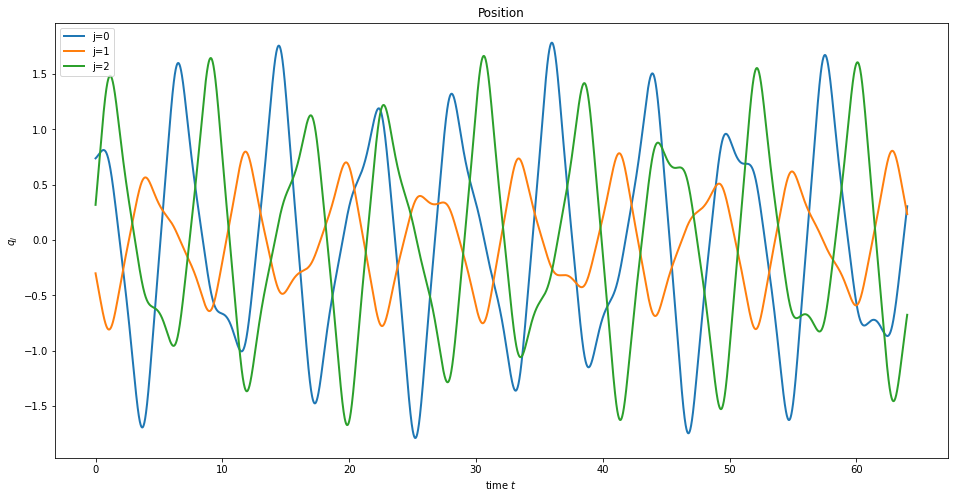

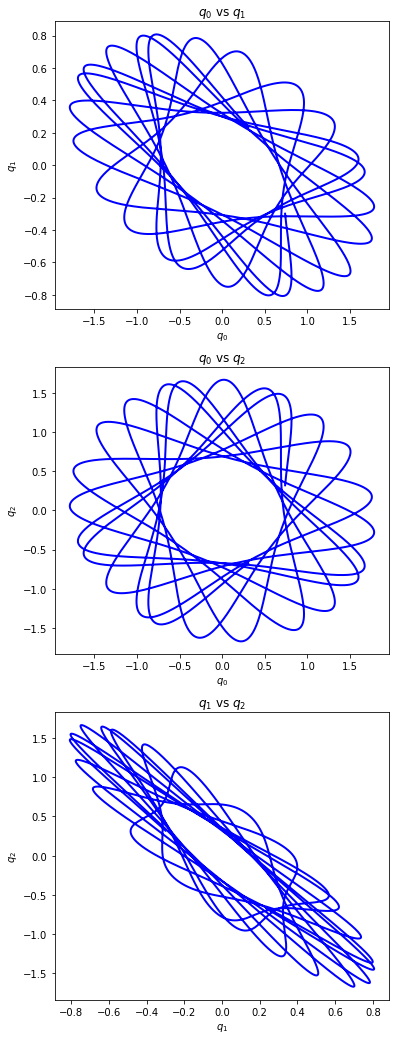

In [10]:
dim = 3
mass = 1.1
mu = 1.2
kappa = 0.97

dynamical_system = DoubleWellPotentialSystem(dim, mass,mu,kappa)
initializer = DoubleWellPotentialConstantInitializer(dim)
monitors = [PositionMonitor(dim)]

trajectory_generator3 = TrajectoryGenerator(dynamical_system,initializer,monitors,dt=0.01,t_final=64.0)
trajectory_generator3.run()

q_all = trajectory_generator3.monitors[0].value

fig = plt.figure(figsize=(16,8))
ax = plt.gca()

for j in range(dim):
    ax.plot(trajectory_generator3.t,q_all[j,:],linewidth=2,label=f"j={j:d}")
ax.set_xlabel("time $t$")
ax.set_ylabel("$q_j$")
ax.legend(loc="upper left")
ax.set_title("Position")

nplots = len(list(combinations(range(dim), 2)))
fig, axs = plt.subplots(nplots,figsize=(6,6*nplots))

for ell, (j,k) in enumerate(combinations(range(dim), 2)):
    axs[ell].plot(q_all[j,:],q_all[k,:],linewidth=2,color="blue")
    axs[ell].set_xlabel(f"$q_{j}$")
    axs[ell].set_ylabel(f"$q_{k}$")
    axs[ell].set_title(f"$q_{j}$ vs $q_{k}$")



## System of two interacting particles

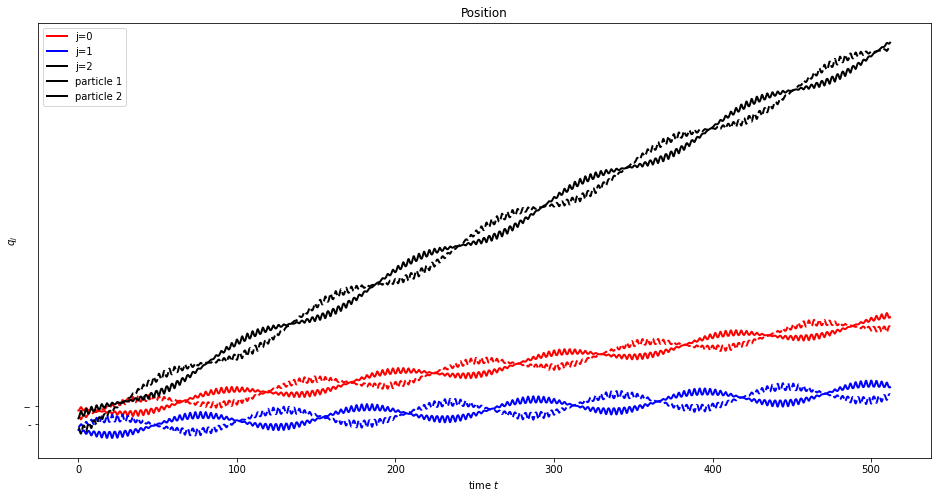

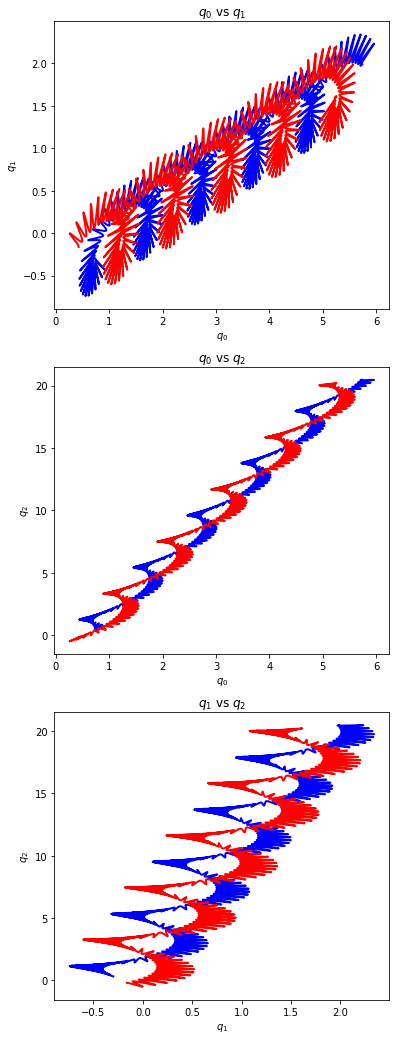

In [3]:
dim_space = 3
dim = 2*dim_space
mass1 = 1.1
mass2 = 0.98
mu = 1.2
kappa = 0.97

dynamical_system = TwoParticleSystem(dim_space, mass1,mass2,mu,kappa)
initializer = TwoParticleConstantInitializer(dim)
monitors = [PositionMonitor(dim)]

trajectory_generator3 = TrajectoryGenerator(dynamical_system,initializer,monitors,dt=0.01,t_final=512.0)
trajectory_generator3.run()

q_all = trajectory_generator3.monitors[0].value

fig = plt.figure(figsize=(16,8))
ax = plt.gca()

colors=['red','blue','black','green','orange']
for j in range(dim_space):
    ax.plot(trajectory_generator3.t,q_all[j,:],linewidth=2,label=f"j={j:d}",color=colors[j])
    ax.plot(trajectory_generator3.t,q_all[dim_space+j,:],linewidth=2,linestyle='--',color=colors[j])
ax.plot('-',color="black",linewidth=2,label="particle 1")
ax.plot('--',color="black",linewidth=2,label="particle 2")
ax.set_xlabel("time $t$")
ax.set_ylabel("$q_j$")
ax.legend(loc="upper left")
ax.set_title("Position")

nplots = len(list(combinations(range(dim_space), 2)))
fig, axs = plt.subplots(nplots,figsize=(6,6*nplots))

for ell, (j,k) in enumerate(combinations(range(dim_space), 2)):
    axs[ell].plot(q_all[j,:],q_all[k,:],linewidth=2,color="blue",label="particle 1")
    axs[ell].plot(q_all[dim_space+j,:],q_all[dim_space+k,:],linewidth=2,color="red",label="particle 2")
    axs[ell].set_xlabel(f"$q_{j}$")
    axs[ell].set_ylabel(f"$q_{k}$")
    axs[ell].set_title(f"$q_{j}$ vs $q_{k}$")
